In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像时负号‘-’显示为方块的问题

from sklearn.model_selection import train_test_split # 分数据集
import sklearn.metrics as metrics # 绘制ROC曲线
import statsmodels.api as sma 

In [2]:
app_data = pd.read_csv('../数据/营销模型建模数据.csv')

In [3]:
app_data.set_index('ID',inplace=True) # 以ID建立索引
app_data.loc[app_data['Xc_marry']=='Single / not married','Xc_marry'] = 'Single_not_married' # 以免进行逐步回归的时候因为变量名不规范而报错
app_data.Xc_mortgage = app_data.Xc_mortgage.astype('int')
app_data.Xc_insurance_pay = app_data.Xc_insurance_pay.astype('int')
app_data.Xc_loan_repay = app_data.Xc_loan_repay.astype('int')
# 因为工作年限分箱后，未知值和3年以下为一类，故将未知值设为1.5
app_data.loc[app_data.Xn_employed=='Unknow','Xn_employed'] = 1.5
app_data.Xn_employed = app_data.Xn_employed.astype(int)

#### 通过随机森林对变量的重要性进行筛选

In [6]:
# 分类变量
var_d = [ 'Xc_gender', 'Xc_car', 'Xc_realty','Xc_income_type', 'Xc_edu', 'Xc_marry', 
        'Xc_housing','Xc_phone', 'Xc_work_phone','Xc_email', 'Xc_occupation',
        'Xc_mortgage', 'Xc_annuity', 'Xc_insurance_pay', 'Xc_loan_repay','Xc_rfm']
# 连续变量
var_c = [ 'Xn_credit_score', 'Xc_score','Xn_age', 'Xn_employed', 'Xn_children','Xn_income',
        'Xn_trades', 'Xn_Avg_amount_num', 'Xn_balance_num', 'Xn_Dif_balance_num', 'Xr_cash',
        'Xr_remit', 'Xr_interest', 'Xr_loan', 'Xr_collection', 'Xr_cc_debit']

x1 = copy.deepcopy(app_data.loc[:,var_c])
x2 = pd.get_dummies(app_data.loc[:,var_d],columns=var_d,drop_first=True) # drop_first 去掉第一个
x = pd.merge(x1,x2,on='ID')
y = app_data.resp

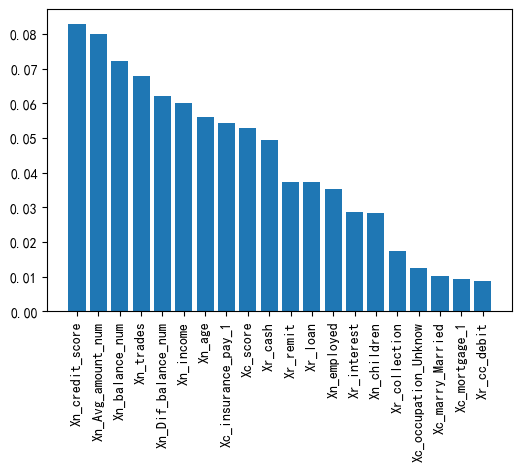

In [7]:
import sklearn.ensemble as ensemble
rfc = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=3,max_features=0.5,min_samples_split=5)
rfc_model = rfc.fit(x,y)
# rfc_model.feature_importances_
# 画图
rfc_fi = pd.DataFrame()
rfc_fi['features'] = list(x.columns)
rfc_fi['importance'] = list(rfc_model.feature_importances_)
rfc_fi = rfc_fi.set_index('features',drop=True)
var_sort = rfc_fi.sort_values(by='importance',ascending=False)
plt.figure(dpi=100);plt.xticks(rotation=90)
plt.bar(var_sort.index[:20],var_sort.importance[:20])

# 以2%作为选取变量的阈值,（之后要与iv取并集）
var_x = list(var_sort.importance[var_sort.importance>0.02].index)
# var_x

#### 初步确定变量，逻辑回归

In [40]:
# 选择IV值和随机森林筛选出来的变量（并集）进入模型
var_d = ['Xc_insurance_pay','Xc_rfm','Xc_mortgage','Xc_marry','Xc_gender','Xc_occupation',
        'Xc_loan_repay']
# 连续变量
var_c = ['Xn_trades', 'Xr_remit','Xr_interest','Xr_loan','Xr_cash','Xn_family','Xr_collection',
        'Xn_children','Xn_balance_num','Xn_credit_score','Xn_Avg_amount_num','Xn_employed',
        'Xn_age','Xn_score','Xn_Dif_balance_num','Xn_income']

x1 = copy.deepcopy(app_data.loc[:,var_c])
x2 = pd.get_dummies(app_data.loc[:,var_d],columns=var_d,drop_first=True) # drop_first 去掉第一个
x = pd.merge(x1,x2,on='ID')
y = app_data.resp

In [41]:
for i in x.columns.values:  # 去掉为0的列，否则会报错
    if x[i].agg(sum) == 0:
        x.drop(i,axis=1,inplace=True)
        print(i)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=0)
lr = sma.Logit(y_train,x_train)
result = lr.fit()
result.summary2()

Xn_score
Optimization terminated successfully.
         Current function value: 0.530036
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
===================================================================================
Model:                    Logit                  Pseudo R-squared:       0.129     
Dependent Variable:       resp                   AIC:                    3421.8052 
Date:                     2020-08-26 10:35       BIC:                    3694.1872 
No. Observations:         3143                   Log-Likelihood:         -1665.9   
Df Model:                 44                     LL-Null:                -1913.2   
Df Residuals:             3098                   LLR p-value:            1.5330e-77
Converged:                1.0000                 Scale:                  1.0000    
No. Iterations:           6.0000                                                   
-----------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
Xn_trades                            0.0326   0.0106  3.0817 0.0021  0.0119  0.0534
Xr_remit                            -0.3178   1.1708 -0.2714 0.7861 -2.6125  1.9770
Xr_interest                          1.6972   1.5604  1.0877 0.2767 -1.3611  4.7556
Xr_loan                              1.3830   1.1749  1.1771 0.2392 -0.9198  3.6858
Xr_cash                              0.5052   0.9625  0.5249 0.5996 -1.3812  2.3916
Xn_family                           -1.7628   0.5894 -2.9909 0.0028 -2.9179 -0.6076
Xr_collection                        1.7913   1.3041  1.3736 0.1696 -0.7647  4.3474
Xn_children                          2.0481   0.5927  3.4556 0.0005  0.8865  3.2097
Xn_balance_num                      -0.0000   0.0000 -1.6575 0.0974 -0.0000  0.0000
Xn_credit_score                     -0.0002   0.0003 -0.6751 0.4996 -0.0008  0.0004
Xn_Avg_amount_num                   -0.0000   0.0000 -0.0133 0.9894 -0.0000  0.0000
Xn_employed                          0.0109   0.0063  1.7213 0.0852 -0.0015  0.0234
Xn_age                              -0.0059   0.0038 -1.5501 0.1211 -0.0134  0.0016
Xn_Dif_balance_num                   0.0000   0.0000  0.6648 0.5062 -0.0000  0.0000
Xn_income                           -0.0000   0.0000 -1.3982 0.1621 -0.0000  0.0000
Xc_insurance_pay_1                   1.3498   0.1896  7.1213 0.0000  0.9783  1.7214
Xc_rfm_一般发展客户                       -0.3247   0.1495 -2.1721 0.0298 -0.6176 -0.0317
Xc_rfm_一般挽留客户                        0.5230   0.7142  0.7323 0.4640 -0.8768  1.9229
Xc_rfm_重要价值客户                        0.2621   0.1983  1.3216 0.1863 -0.1266  0.6508
Xc_rfm_重要发展客户                       -0.3204   0.2476 -1.2940 0.1957 -0.8057  0.1649
Xc_mortgage_1                        0.9543   0.1528  6.2473 0.0000  0.6549  1.2537
Xc_marry_Married                     0.2161   0.1532  1.4107 0.1583 -0.0841  0.5163
Xc_marry_Separated                  -1.9345   0.6196 -3.1220 0.0018 -3.1489 -0.7200
Xc_marry_Single_not_married         -2.1637   0.6060 -3.5702 0.0004 -3.3516 -0.9759
Xc_marry_Widow                      -1.9787   0.6362 -3.1102 0.0019 -3.2256 -0.7318
Xc_gender_M                          0.5967   0.1044  5.7155 0.0000  0.3921  0.8013
Xc_occupation_Cleaning staff         0.1203   0.4493  0.2678 0.7889 -0.7603  1.0009
Xc_occupation_Cooking staff         -0.2740   0.4410 -0.6213 0.5344 -1.1383  0.5904
Xc_occupation_Core staff             0.1311   0.2681  0.4891 0.6248 -0.3943  0.6565
Xc_occupation_Drivers               -0.4080   0.3013 -1.3542 0.1757 -0.9986  0.1825
Xc_occupation_HR staff               1.0953   0.9108  1.2026 0.2291 -0.6898  2.8804
Xc_occupation_High skill tech staff -0.1502   0.3175 -0.4731 0.6362 -0.7724  0.4721
Xc_occupation_IT staff              -0.7573   1.1589 -0.6534 0.5135 -3.0287  1.5142
Xc_occupation_Laborers               0.1573   0.2546  0.6176 0.5369 -0.3418  0.6563
Xc_occupation_Low-skill Laborers    -1

#### 向前回归

In [42]:
var_drop = [] # 一个个去掉p值大于0.3的
while max(result.pvalues)>0.3:
    var_drop.append(result.pvalues.idxmax())
    x1 = x.drop(var_drop,axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=0.3,random_state=0)
    lr = sma.Logit(y_train,x_train)
    result = lr.fit()

var_drop

Optimization terminated successfully.
         Current function value: 0.530036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530265
  

['Xn_Avg_amount_num',
 'Xc_occupation_Unknow',
 'Xc_occupation_Cleaning staff',
 'Xr_remit',
 'Xc_occupation_Security staff',
 'Xc_occupation_Core staff',
 'Xc_occupation_Sales staff',
 'Xc_occupation_Medicine staff',
 'Xc_occupation_Laborers',
 'Xc_occupation_Private service staff',
 'Xc_occupation_Waiters/barmen staff',
 'Xn_Dif_balance_num',
 'Xn_credit_score',
 'Xc_loan_repay_1',
 'Xc_rfm_一般挽留客户',
 'Xc_occupation_IT staff',
 'Xc_occupation_Realty agents']

In [43]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
===================================================================================
Model:                    Logit                  Pseudo R-squared:       0.128     
Dependent Variable:       resp                   AIC:                    3392.7604 
Date:                     2020-08-26 10:35       BIC:                    3562.2425 
No. Observations:         3143                   Log-Likelihood:         -1668.4   
Df Model:                 27                     LL-Null:                -1913.2   
Df Residuals:             3115                   LLR p-value:            2.1084e-86
Converged:                1.0000                 Scale:                  1.0000    
No. Iterations:           6.0000                                                   
-----------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
Xn_trades                            0.0273   0.0087  3.1231 0.0018  0.0102  0.0444
Xr_interest                          1.6129   1.2112  1.3316 0.1830 -0.7610  3.9867
Xr_loan                              1.8867   0.8102  2.3286 0.0199  0.2987  3.4747
Xr_cash                              0.7954   0.5482  1.4510 0.1468 -0.2790  1.8698
Xn_family                           -1.8209   0.3662 -4.9729 0.0000 -2.5385 -1.1032
Xr_collection                        2.2529   1.0314  2.1844 0.0289  0.2315  4.2744
Xn_children                          2.1097   0.3727  5.6599 0.0000  1.3791  2.8403
Xn_balance_num                      -0.0000   0.0000 -1.6023 0.1091 -0.0000  0.0000
Xn_employed                          0.0112   0.0063  1.7658 0.0774 -0.0012  0.0236
Xn_age                              -0.0057   0.0038 -1.4991 0.1338 -0.0132  0.0018
Xn_income                           -0.0000   0.0000 -1.4116 0.1581 -0.0000  0.0000
Xc_insurance_pay_1                   1.3822   0.1709  8.0901 0.0000  1.0474  1.7171
Xc_rfm_一般发展客户                       -0.3490   0.1380 -2.5288 0.0114 -0.6195 -0.0785
Xc_rfm_重要价值客户                        0.2442   0.1540  1.5855 0.1129 -0.0577  0.5461
Xc_rfm_重要发展客户                       -0.3665   0.2058 -1.7811 0.0749 -0.7697  0.0368
Xc_mortgage_1                        0.9553   0.1385  6.8972 0.0000  0.6839  1.2268
Xc_marry_Married                     0.2189   0.1523  1.4371 0.1507 -0.0797  0.5175
Xc_marry_Separated                  -1.9935   0.4090 -4.8742 0.0000 -2.7952 -1.1919
Xc_marry_Single_not_married         -2.2209   0.3925 -5.6582 0.0000 -2.9901 -1.4516
Xc_marry_Widow                      -2.0642   0.4328 -4.7695 0.0000 -2.9125 -1.2159
Xc_gender_M                          0.5914   0.0974  6.0742 0.0000  0.4006  0.7823
Xc_occupation_Cooking staff         -0.3964   0.3801 -1.0428 0.2971 -1.1414  0.3487
Xc_occupation_Drivers               -0.5192   0.1915 -2.7111 0.0067 -0.8945 -0.1438
Xc_occupation_HR staff               1.0132   0.8822  1.1485 0.2508 -0.7158  2.7422
Xc_occupation_High skill tech staff -0.2644   0.2252 -1.1739 0.2404 -0.7059  0.1770
Xc_occupation_Low-skill Laborers    -1.2865   0.8090 -1.5902 0.1118 -2.8722  0.2992
Xc_occupation_Managers               0.1683   0.1573  1.0700 0.2846 -0.1400  0.4767
Xc_occupation_Secretaries            0.7769   0.5057  1.5364 0.1244 -0.2142  1.7679
===================================================================================

"""

#### 保存数据

In [13]:
var_finall = x_train.columns.values
# 分类变量
var_d = ['Xc_insurance_pay','Xc_rfm','Xc_mortgage','Xc_marry','Xc_gender','Xc_occupation',
        'Xc_loan_repay']
# 连续变量
var_c = ['Xn_trades', 'Xr_remit','Xr_interest','Xr_loan','Xr_cash','Xn_family','Xr_collection',
        'Xn_children','Xn_balance_num','Xn_credit_score','Xn_Avg_amount_num','Xn_employed',
        'Xn_age','Xn_score','Xn_Dif_balance_num','Xn_income']

x1 = copy.deepcopy(app_data.loc[:,var_c])
x2 = pd.get_dummies(app_data.loc[:,var_d],columns=var_d,drop_first=True) # drop_first 去掉第一个
x = pd.merge(x1,x2,on='ID')
data = x.loc[:,var_finall]
data.insert(0,'resp',app_data.resp)
data.to_csv('../数据/营销模型建模数据2.csv')

#### 混淆矩阵

In [44]:
# 根据ROC设置的阈值为：0.90598291
test = pd.DataFrame(result.predict(x_test),columns=['pre'])
test['true'] = y_test.values
test['pre2'] = test['pre'].apply(lambda x: 1 if x>=0.5 else 0)

train = pd.DataFrame(result.predict(x_train),columns=['pre'])
train['true'] = y_train.values
train['pre2'] = train['pre'].apply(lambda x: 1 if x>=0.5 else 0)

hx = pd.DataFrame()
hx['1'] = ['训练集','训练集','测试集','测试集']
hx['2'] = ['预测为0','预测为1','预测为0','预测为1']
hx.loc[0,'实际为0'] = (train[train['true']==0]['pre2'] == train[train['true']==0]['true']).agg(sum)
hx.loc[1,'实际为0'] = len(train[train['true']==0]) - hx.loc[0,'实际为0']
hx.loc[0,'实际为1'] = (train[train['true']==1]['pre2'] != train[train['true']==1]['true']).agg(sum)
hx.loc[1,'实际为1'] = (train[train['true']==1]['pre2'] == train[train['true']==1]['true']).agg(sum)

hx.loc[2,'实际为0'] = (test[test['true']==0]['pre2'] == test[test['true']==0]['true']).agg(sum)
hx.loc[3,'实际为0'] = len(test[test['true']==0]) - hx.loc[2,'实际为0']
hx.loc[2,'实际为1'] = (test[test['true']==1]['pre2'] != test[test['true']==1]['true']).agg(sum)
hx.loc[3,'实际为1'] = (test[test['true']==1]['pre2'] == test[test['true']==1]['true']).agg(sum)

hx.set_index(['1','2'],inplace=True)

hx.loc['训练集','预测准确率'] = format((train['pre2'] == train['true']).agg(sum)/len(train),'.2%')
hx.loc['测试集','预测准确率'] = format((test['pre2'] == test['true']).agg(sum)/len(test),'.2%')

hx.loc['训练集','接受营销用户预测准确率'] = format(hx['实际为1'][1]/(train.true==1).agg(sum),'.2%')
hx.loc['测试集','接受营销用户预测准确率'] = format(hx['实际为1'][3]/(test.true==1).agg(sum),'.2%')
hx

实际为0   实际为1   预测准确率 接受营销用户预测准确率
1   2                                      
训练集 预测为0  2066.0  649.0  74.83%      30.59%
    预测为1   142.0  286.0  74.83%      30.59%
测试集 预测为0   866.0  278.0  74.16%      32.36%
    预测为1    70.0  133.0  74.16%      32.36%

#### ROC曲线

Text(0.5, 1.0, 'ROC曲线(不分箱)')

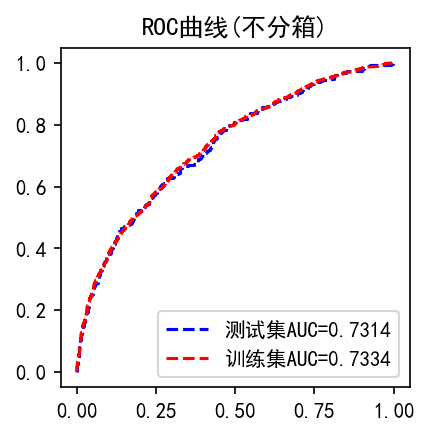

In [45]:
fpr_test,tpr_test,th_test = metrics.roc_curve(test.true,test.pre) # 测试集
fpr_train,tpr_train,th_train = metrics.roc_curve(train.true,train.pre) # 训练集
plt.figure(dpi=150,figsize=(3,3))
plt.plot(fpr_test,tpr_test,'b--',label=f'测试集AUC={round(metrics.auc(fpr_test,tpr_test),4)}')
plt.plot(fpr_train,tpr_train,'r--',label=f'训练集AUC={round(metrics.auc(fpr_train,tpr_train),4)}')
plt.legend();plt.title('ROC曲线(不分箱)')

#### 分箱的逻辑回归

In [4]:
x = pd.DataFrame(index=app_data.index)
# 表现期交易次数
x.loc[app_data['Xn_trades']<25,'Xc_trades_1'] = 1
x.loc[app_data['Xn_trades'].isin(np.arange(25,40)),'Xn_trades_2'] = 1
x.loc[app_data['Xn_trades'].isin(np.arange(40,42)),'Xn_trades_3'] = 1
x.loc[app_data['Xn_trades'].isin(np.arange(42,49)),'Xn_trades_4'] = 1
x.loc[app_data['Xn_trades'].isin(np.arange(49,53)),'Xn_trades_5'] = 1

# 是否有保险交易
x['Xc_insurance_pay'] = app_data.Xc_insurance_pay

# 汇款次数占比
x.loc[app_data['Xr_remit']<0.095,'Xc_remit_1'] = 1
x.loc[app_data['Xr_remit'].isin(np.arange(0.095,0.235,0.001)),'Xr_remit_2'] = 1
x.loc[app_data['Xr_remit'].isin(np.arange(0.235,0.325,0.001)),'Xr_remit_3'] = 1

# 利息交易次数占比
x.loc[app_data['Xr_interest']<0.115,'Xc_interes_1'] = 1
x.loc[app_data['Xr_interest'].isin(np.arange(0.115,0.125,0.001)),'Xr_interest_2'] = 1
x.loc[app_data['Xr_interest'].isin(np.arange(0.125,0.135,0.001)),'Xr_interest_3'] = 1
x.loc[app_data['Xr_interest'].isin(np.arange(0.135,0.145,0.001)),'Xr_interest_4'] = 1
x.loc[app_data['Xr_interest'].isin(np.arange(0.145,0.165,0.001)),'Xr_interest_5'] = 1
x.loc[app_data['Xr_interest'].isin(np.arange(0.165,0.245,0.001)),'Xr_interest_6'] = 1

# 是否有房贷
x['Xc_mortgage'] = app_data.Xc_mortgage

# 贷款交易次数占比
x.loc[app_data['Xr_loan']<0.05,'Xc_loan_1'] = 1
x.loc[app_data['Xr_loan'].isin(np.arange(0.05,0.095,0.001)),'Xr_loan_2'] = 1
x.loc[app_data['Xr_loan'].isin(np.arange(0.095,0.125,0.001)),'Xr_loan_3'] = 1
x.loc[app_data['Xr_loan'].isin(np.arange(0.125,0.145,0.001)),'Xr_loan_4'] = 1
x.loc[app_data['Xr_loan'].isin(np.arange(0.145,0.295,0.001)),'Xr_loan_5'] = 1

# 现金支取次数占比
x.loc[app_data['Xr_cash']<0.345,'Xc_cash_1'] = 1
x.loc[app_data['Xr_cash'].isin(np.arange(0.345,0.445,0.001)),'Xr_cash_2'] = 1
x.loc[app_data['Xr_cash'].isin(np.arange(0.445,0.585,0.001)),'Xr_cash_3'] = 1

# 家庭人数
x.loc[app_data['Xn_family']==1,'Xn_family_1'] = 1
x.loc[app_data['Xn_family']==2,'Xn_family_2'] = 1
x.loc[app_data['Xn_family']==3,'Xn_family_3'] = 1

# 收款次数占比
x.loc[app_data['Xr_collection']<0.045,'Xr_collection_1'] = 1
x.loc[app_data['Xr_collection'].isin(np.arange(0.045,0.145,0.001)),'Xr_collection_2'] = 1
x.loc[app_data['Xr_collection'].isin(np.arange(0.145,0.175,0.001)),'Xr_collection_3'] = 1
x.loc[app_data['Xr_collection'].isin(np.arange(0.175,0.195,0.001)),'Xr_collection_4'] = 1

# 表现期最后一天的账户余额
x.loc[app_data['Xn_balance_num']<15668,'Xn_balance_num_1'] = 1
x.loc[app_data['Xn_balance_num'].isin(range(15668,43879)),'Xn_balance_num_2'] = 1

# 信用局评分
x.loc[app_data['Xn_credit_score']<416,'Xc_credit_score_1'] = 1
x.loc[app_data['Xn_credit_score'].isin(range(416,534)),'Xn_credit_score_2'] = 1
x.loc[app_data['Xn_credit_score'].isin(range(534,642)),'Xn_credit_score_3'] = 1
x.loc[app_data['Xn_credit_score'].isin(range(642,663)),'Xn_credit_score_4'] = 1

# rfm
x.loc[app_data['Xc_rfm']=='重要价值客户','Xc_rfm_1'] = 1
x.loc[app_data['Xc_rfm']=='重要发展客户','Xc_rfm_2'] = 1
x.loc[app_data['Xc_rfm']=='一般价值客户','Xc_rfm_3'] = 1
x.loc[app_data['Xc_rfm']=='一般发展客户','Xc_rfm_4'] = 1

# 性别
x.loc[app_data['Xc_gender']=='F','Xc_gender'] = 1

# 孩子个数
x.loc[app_data['Xn_children']==0,'Xn_children_1'] = 1
x.loc[app_data['Xn_children']==1,'Xn_children_2'] = 1

# 婚姻状况
x.loc[app_data.Xc_marry=='Married','Xc_marry_1'] = 1
x.loc[app_data.Xc_marry=='Civil marriage','Xc_marry_2'] = 1
x.loc[app_data.Xc_marry=='Separated','Xc_marry_3'] = 1
x.loc[app_data.Xc_marry=='Widow','Xc_marry_4'] = 1



# 每次平均交易金额
x.loc[app_data['Xn_Avg_amount_num']<2292,'Xn_Avg_amount_num_1'] = 1
x.loc[app_data['Xn_Avg_amount_num'].isin(range(2292,6469)),'Xn_Avg_amount_num_2'] = 1

# 工作年限
x.loc[app_data['Xn_employed']<4,'Xn_employed_1'] = 1
x.loc[app_data['Xn_employed']==4,'Xn_employed_2'] = 1
x.loc[app_data['Xn_employed']>4,'Xn_employed_3'] = 1

# 年龄
x.loc[app_data['Xn_age']<48,'Xn_age_1'] = 1
x.loc[app_data['Xn_age'].isin(range(48,51)),'Xn_age_2'] = 1

# 风险评分
x.loc[app_data['Xc_score']<730,'Xc_score_1'] = 1
x.loc[app_data['Xc_score'].isin(range(730,744)),'Xc_score_2'] = 1

# 职业 “其他”不加入
x.loc[app_data['Xc_occupation']=='Laborers','Xc_occupation_1'] = 1
x.loc[app_data['Xc_occupation']=='Managers','Xc_occupation_2'] = 1
x.loc[app_data['Xc_occupation']=='Core staff','Xc_occupation_3'] = 1
x.loc[app_data['Xc_occupation']=='Unknow','Xc_occupation_4'] = 1
x.loc[app_data['Xc_occupation']=='Sales staff','Xc_occupation_5'] = 1
x.loc[app_data['Xc_occupation']=='Drivers','Xc_occupation_6'] = 1

# 账户余额在表现期的总变动
x.loc[app_data['Xn_Dif_balance_num']<-26846,'Xn_Dif_balance_num_1'] = 1
x.loc[app_data['Xn_Dif_balance_num'].isin(range(-26846,-13317)),'Xn_Dif_balance_num_2'] = 1

# 是否有贷款交易
x['Xc_loan_repay'] = app_data.Xc_loan_repay

# 年收入
x.loc[app_data['Xn_income']<133425,'Xn_income_1'] = 1
x.loc[app_data['Xn_income'].isin(range(133425,384750)),'Xn_income_2'] = 1

# # # 是否有车
# # dic1 = {'Y':1,'N':0}
# # x['Xc_car'] = app_data.FLAG_OWN_CAR.apply(lambda x: dic1[x])

# # 是否有养老金
# x['Xc_annuity'] = app_data.Xc_annuity

# # 信用卡交易次数占比
# x.loc[app_data['Xc_cc_debit']<0.045,'Xc_cc_debit_1'] = 1

# #  教育程度(其他不放入)
# x.loc[app_data['NAME_EDUCATION_TYPE']=='Higher education','Xc_edu_1'] = 1
# x.loc[app_data['NAME_EDUCATION_TYPE']=='Secondary / secondary special','Xc_edu_2'] = 1

# # 收入类型
# x.loc[app_data['NAME_INCOME_TYPE']=='State servant','Xc_income_type_1'] = 1
# x.loc[app_data['NAME_INCOME_TYPE']=='Working','Xc_income_type_2'] = 1
# x.loc[app_data['NAME_INCOME_TYPE']=='Pensioner','Xc_income_type_3'] = 1

# # 是否有工作电话
# x['Xc_work_phone'] = app_data.FLAG_WORK_PHONE

# # 是否有房产
# x['Xc_realty'] = app_data['FLAG_OWN_REALTY_Y']

# # 居住方式
# x.loc[app_data['NAME_HOUSING_TYPE']=='House / apartment','Xc_housing_1'] = 1

# # 是否有邮件
# x['Xc_email'] = app_data.FLAG_EMAIL

x.fillna(0,inplace=True)

In [5]:
x

,Xc_trades_1,Xn_trades_2,Xn_trades_3,Xn_trades_4,Xn_trades_5,Xc_insurance_pay,Xc_remit_1,Xr_remit_2,Xr_remit_3,Xc_interes_1,...,Xc_occupation_2,Xc_occupation_3,Xc_occupation_4,Xc_occupation_5,Xc_occupation_6,Xn_Dif_balance_num_1,Xn_Dif_balance_num_2,Xc_loan_repay,Xn_income_1,Xn_income_2
ID,,,,,,,,,,,,,,,,,,,,,
5112862,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
5009180,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
5009222,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
5009363,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,1.0
6153587,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6620651,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,1.0
6640133,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
6651183,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0


In [6]:
# 初步建立模型
y = app_data.resp
for i in x.columns.values:  # 去掉为0的列，否则会报错
    if x[i].agg(sum) == 0:
        x.drop(i,axis=1,inplace=True)
        print(i)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=0)
lr = sma.Logit(y_train,x_train)
result = lr.fit()
result.summary2()

Xr_interest_2
Xr_collection_2
Optimization terminated successfully.
         Current function value: 0.520733
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Pseudo R-squared:  0.145     
Dependent Variable:  resp              AIC:               3405.3295 
Date:                2020-08-29 15:19  BIC:               3804.8231 
No. Observations:    3143              Log-Likelihood:    -1636.7   
Df Model:            65                LL-Null:           -1913.2   
Df Residuals:        3077              LLR p-value:       1.5911e-78
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Xc_trades_1          -1.4829   0.5553 -2.6704 0.0076 -2.5712 -0.3945
Xn_trades_2          -1.1677   0.4954 -2.3569 0.0184 -2.1386 -0.1967
Xn_trades_3          -1.6772   0.4683 -3.5818 0.0003 -2.5949 -0.7594
Xn_trades_4          -1.7394   0.4930 -3.5281 0.0004 -2.7057 -0.7731
Xn_trades_5          -0.9365   0.4113 -2.2769 0.0228 -1.7426 -0.1304
Xc_insurance_pay      1.3180   0.1983  6.6450 0.0000  0.9292  1.7067
Xc_remit_1            0.1403   0.2135  0.6569 0.5112 -0.2782  0.5587
Xr_remit_2           -0.2506   0.7482 -0.3349 0.7377 -1.7170  1.2158
Xr_remit_3            0.1590   0.1857  0.8561 0.3920 -0.2050  0.5231
Xc_interes_1         -0.8456   0.4026 -2.1005 0.0357 -1.6347 -0.0566
Xr_interest_3         0.7156   0.3503  2.0430 0.0410  0.0291  1.4021
Xr_interest_4         0.5144   0.3412  1.5079 0.1316 -0.1542  1.1831
Xr_interest_5         0.3468   0.1819  1.9064 0.0566 -0.0097  0.7033
Xr_interest_6         0.3050   0.2036  1.4979 0.1341 -0.0941  0.7041
Xc_mortgage           0.9553   0.1937  4.9321 0.0000  0.5757  1.3350
Xc_loan_1            -0.2130   0.2353 -0.9052 0.3653 -0.6740  0.2481
Xr_loan_2            -2.8085   1.0668 -2.6327 0.0085 -4.8993 -0.7177
Xr_loan_3            -0.3237   0.4464 -0.7252 0.4683 -1.1986  0.5512
Xr_loan_4            -0.0219   0.1931 -0.1137 0.9095 -0.4004  0.3565
Xr_loan_5            -0.0786   0.1488 -0.5282 0.5974 -0.3703  0.2131
Xc_cash_1            -0.1333   0.1435 -0.9288 0.3530 -0.4146  0.1480
Xr_cash_2            -0.3513   0.1358 -2.5872 0.0097 -0.6174 -0.0852
Xr_cash_3            -0.2062   0.1213 -1.6995 0.0892 -0.4440  0.0316
Xn_family_1           1.2866   3.5175  0.3658 0.7145 -5.6075  8.1807
Xn_family_2           1.1723   2.3740  0.4938 0.6215 -3.4808  5.8253
Xn_family_3           0.7754   1.2481  0.6213 0.5344 -1.6708  3.2215
Xr_collection_1      -0.2611   0.2410 -1.0837 0.2785 -0.7334  0.2112
Xr_collection_3       0.0069   0.2143  0.0320 0.9745 -0.4132  0.4269
Xr_collection_4      -0.1262   0.2150 -0.5871 0.5571 -0.5476  0.2952
Xn_balance_num_1      0.0612   0.1746  0.3504 0.7261 -0.2811  0.4035
Xn_balance_num_2      0.0756   0.1117  0.6772 0.4983 -0.1432  0.2945
Xc_credit_score_1     0.2935   0.1919  1.5293 0.1262 -0.0827  0.6696
Xn_credit_score_2    -0.0275   0.1238 -0.2218 0.8244 -0.2701  0.2152
Xn_credit_score_3    -0.2781   0.1124 -2.4733 0.0134 -0.4985 -0.0577
Xn_credit_score_4    -0.3086   0.2193 -1.4074 0.1593 -0.7384  0.1212
Xc_rfm_1             -0.2877   0.7486 -0.3843 0.7007 -1.7549  1.1795
Xc_rfm_2             -1.1556   0.7055 -1.6381 0.1014 -2.5383  0.2270
Xc_rfm_3             -0.6328   0.7265 -0.8709 0.3838 -2.0568  0.7912
Xc_rfm_4             -1.1583   0.6652 -1.7413 0.0816 -2.4622  0.1455
Xc_gender            -0.5946   0.1069 -5.5615 0.0000 -0.8042 -0.3851
Xn_children_1        -1.5508   2.3790 -0.6519 0.5145 -6.2136  3.1119
Xn_children_2        -0.5885   1.2526 -0.4698 0.6385 -3.0437  1.8666
Xc_marry_1            0.7920   1.1700  0.6769 0.4985 -1.5012  3.0852
Xc_marry_2            0.5150   1.1775  0.4374 0.6618 -1.7928  2.8228
Xc_marry_3            0.1504   0.2335  0.6441

#### 向前逐步回归

In [7]:
var_drop = [] # 一个个去掉p值大于0.3的
while max(result.pvalues)>0.3:
    var_drop.append(result.pvalues.idxmax())
    x1 = x.drop(var_drop,axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=0.3,random_state=0)
    lr = sma.Logit(y_train,x_train)
    result = lr.fit()

var_drop

Optimization terminated successfully.
         Current function value: 0.520733
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520744
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520797
  

['Xr_collection_3',
 'Xr_loan_4',
 'Xc_occupation_4',
 'Xn_income_2',
 'Xn_Avg_amount_num_1',
 'Xn_Avg_amount_num_2',
 'Xn_credit_score_2',
 'Xn_Dif_balance_num_1',
 'Xn_employed_1',
 'Xc_rfm_1',
 'Xr_remit_2',
 'Xc_occupation_3',
 'Xn_balance_num_1',
 'Xc_loan_repay',
 'Xc_occupation_5',
 'Xc_score_1',
 'Xc_occupation_1',
 'Xn_employed_2',
 'Xr_loan_5',
 'Xr_loan_3',
 'Xc_marry_3',
 'Xn_balance_num_2',
 'Xc_marry_4',
 'Xc_occupation_2',
 'Xc_loan_1',
 'Xn_age_2',
 'Xn_age_1',
 'Xr_collection_4',
 'Xc_cash_1',
 'Xn_family_1',
 'Xn_children_2',
 'Xc_marry_2',
 'Xr_collection_1',
 'Xr_remit_3']

In [9]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:               Logit             Pseudo R-squared:  0.142     
Dependent Variable:  resp              AIC:               3347.5209 
Date:                2020-08-29 15:20  BIC:               3541.2148 
No. Observations:    3143              Log-Likelihood:    -1641.8   
Df Model:            31                LL-Null:           -1913.2   
Df Residuals:        3111              LLR p-value:       7.9473e-95
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Xc_trades_1          -1.1983   0.3582 -3.3448 0.0008 -1.9004 -0.4961
Xn_trades_2          -0.8478   0.3211 -2.6403 0.0083 -1.4771 -0.2184
Xn_trades_3          -1.3767   0.3068 -4.4871 0.0000 -1.9780 -0.7753
Xn_trades_4          -1.3911   0.3715 -3.7450 0.0002 -2.1191 -0.6631
Xn_trades_5          -0.6248   0.2601 -2.4018 0.0163 -1.1346 -0.1149
Xc_insurance_pay      1.2269   0.1734  7.0760 0.0000  0.8871  1.5668
Xc_remit_1            0.2114   0.1837  1.1511 0.2497 -0.1486  0.5714
Xc_interes_1         -0.5778   0.2511 -2.3006 0.0214 -1.0700 -0.0856
Xr_interest_3         0.7073   0.3433  2.0601 0.0394  0.0344  1.3801
Xr_interest_4         0.5025   0.3349  1.5003 0.1335 -0.1540  1.1590
Xr_interest_5         0.3419   0.1465  2.3337 0.0196  0.0548  0.6291
Xr_interest_6         0.3398   0.1635  2.0788 0.0376  0.0194  0.6601
Xc_mortgage           1.0092   0.1717  5.8765 0.0000  0.6726  1.3458
Xr_loan_2            -2.6055   1.0524 -2.4758 0.0133 -4.6681 -0.5428
Xr_cash_2            -0.2713   0.1152 -2.3540 0.0186 -0.4972 -0.0454
Xr_cash_3            -0.1752   0.1125 -1.5571 0.1194 -0.3957  0.0453
Xn_family_2           0.2567   0.1300  1.9741 0.0484  0.0018  0.5116
Xn_family_3           0.2603   0.1516  1.7168 0.0860 -0.0369  0.5574
Xc_credit_score_1     0.2544   0.1381  1.8417 0.0655 -0.0163  0.5252
Xn_credit_score_3    -0.2688   0.1019 -2.6389 0.0083 -0.4685 -0.0692
Xn_credit_score_4    -0.2698   0.2111 -1.2782 0.2012 -0.6836  0.1439
Xc_rfm_2             -0.8802   0.3142 -2.8013 0.0051 -1.4961 -0.2644
Xc_rfm_3             -0.2855   0.1514 -1.8851 0.0594 -0.5823  0.0113
Xc_rfm_4             -0.8569   0.2788 -3.0733 0.0021 -1.4034 -0.3104
Xc_gender            -0.5793   0.0966 -5.9989 0.0000 -0.7686 -0.3900
Xn_children_1        -0.5955   0.1410 -4.2247 0.0000 -0.8718 -0.3193
Xc_marry_1            0.3229   0.1087  2.9702 0.0030  0.1098  0.5360
Xn_employed_3         0.1348   0.0855  1.5755 0.1151 -0.0329  0.3024
Xc_score_2           -0.3133   0.1683 -1.8618 0.0626 -0.6432  0.0165
Xc_occupation_6      -0.5279   0.1894 -2.7874 0.0053 -0.8991 -0.1567
Xn_Dif_balance_num_2 -0.3166   0.1417 -2.2348 0.0254 -0.5943 -0.0389
Xn_income_1           0.1483   0.0973  1.5254 0.1272 -0.0423  0.3390
====================================================================

"""

In [8]:
# 保存数据
x1.insert(0,'resp',app_data.resp)
x1.to_csv('../数据/营销模型建模数据3(分箱).csv')

In [11]:
# 根据ROC设置的阈值为：0.90598291
test = pd.DataFrame(result.predict(x_test),columns=['pre'])
test['true'] = y_test.values
test['pre2'] = test['pre'].apply(lambda x: 1 if x>=0.5 else 0)

train = pd.DataFrame(result.predict(x_train),columns=['pre'])
train['true'] = y_train.values
train['pre2'] = train['pre'].apply(lambda x: 1 if x>=0.5 else 0)

hx = pd.DataFrame()
hx['1'] = ['训练集','训练集','测试集','测试集']
hx['2'] = ['预测为0','预测为1','预测为0','预测为1']
hx.loc[0,'实际为0'] = (train[train['true']==0]['pre2'] == train[train['true']==0]['true']).agg(sum)
hx.loc[1,'实际为0'] = len(train[train['true']==0]) - hx.loc[0,'实际为0']
hx.loc[0,'实际为1'] = (train[train['true']==1]['pre2'] != train[train['true']==1]['true']).agg(sum)
hx.loc[1,'实际为1'] = (train[train['true']==1]['pre2'] == train[train['true']==1]['true']).agg(sum)

hx.loc[2,'实际为0'] = (test[test['true']==0]['pre2'] == test[test['true']==0]['true']).agg(sum)
hx.loc[3,'实际为0'] = len(test[test['true']==0]) - hx.loc[2,'实际为0']
hx.loc[2,'实际为1'] = (test[test['true']==1]['pre2'] != test[test['true']==1]['true']).agg(sum)
hx.loc[3,'实际为1'] = (test[test['true']==1]['pre2'] == test[test['true']==1]['true']).agg(sum)

hx.set_index(['1','2'],inplace=True)

hx.loc['训练集','预测准确率'] = format((train['pre2'] == train['true']).agg(sum)/len(train),'.2%')
hx.loc['测试集','预测准确率'] = format((test['pre2'] == test['true']).agg(sum)/len(test),'.2%')

hx.loc['训练集','接受营销用户预测准确率'] = format(hx['实际为1'][1]/(train.true==1).agg(sum),'.2%')
hx.loc['测试集','接受营销用户预测准确率'] = format(hx['实际为1'][3]/(test.true==1).agg(sum),'.2%')
hx

实际为0   实际为1   预测准确率 接受营销用户预测准确率
1   2                                      
训练集 预测为0  2047.0  620.0  75.15%      33.69%
    预测为1   161.0  315.0  75.15%      33.69%
测试集 预测为0   856.0  267.0  74.24%      35.04%
    预测为1    80.0  144.0  74.24%      35.04%

#### ROC

Text(0.5, 1.0, 'ROC曲线(分箱)')

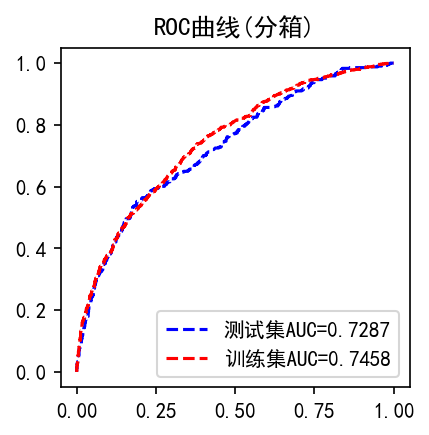

In [12]:
fpr_test,tpr_test,th_test = metrics.roc_curve(test.true,test.pre) # 测试集
fpr_train,tpr_train,th_train = metrics.roc_curve(train.true,train.pre) # 训练集
plt.figure(dpi=150,figsize=(3,3))
plt.plot(fpr_test,tpr_test,'b--',label=f'测试集AUC={round(metrics.auc(fpr_test,tpr_test),4)}')
plt.plot(fpr_train,tpr_train,'r--',label=f'训练集AUC={round(metrics.auc(fpr_train,tpr_train),4)}')
plt.legend();plt.title('ROC曲线(分箱)')

#### 保存1998年下半年要预测的数据

In [56]:
data1 = pd.read_csv('../数据/营销模型建模数据1998下半年.csv')
data1.set_index('ID',inplace=True) # 以ID建立索引
data1.loc[data1['Xc_marry']=='Single / not married','Xc_marry'] = 'Single_not_married' # 以免进行逐步回归的时候因为变量名不规范而报错
data1.Xc_mortgage = data1.Xc_mortgage.astype('int')
data1.Xc_insurance_pay = data1.Xc_insurance_pay.astype('int')
data1.Xc_loan_repay = data1.Xc_loan_repay.astype('int')
# 因为工作年限分箱后，未知值和3年以下为一类，故将未知值设为1.5
data1.loc[data1.Xn_employed=='Unknow','Xn_employed'] = 1.5
data1.Xn_employed = data1.Xn_employed.astype(int)

In [51]:
x = pd.DataFrame(index=data1.index)
# 表现期交易次数
x.loc[data1['Xn_trades']<25,'Xc_trades_1'] = 1
x.loc[data1['Xn_trades'].isin(np.arange(25,40)),'Xn_trades_2'] = 1
x.loc[data1['Xn_trades'].isin(np.arange(40,42)),'Xn_trades_3'] = 1
x.loc[data1['Xn_trades'].isin(np.arange(42,49)),'Xn_trades_4'] = 1
x.loc[data1['Xn_trades'].isin(np.arange(49,53)),'Xn_trades_5'] = 1

# 是否有保险交易
x['Xc_insurance_pay'] = app_data.Xc_insurance_pay

# 汇款次数占比
x.loc[data1['Xr_remit']<0.095,'Xc_remit_1'] = 1
x.loc[data1['Xr_remit'].isin(np.arange(0.095,0.235,0.001)),'Xr_remit_2'] = 1
x.loc[data1['Xr_remit'].isin(np.arange(0.235,0.325,0.001)),'Xr_remit_3'] = 1

# 利息交易次数占比
x.loc[data1['Xr_interest']<0.115,'Xc_interes_1'] = 1
x.loc[data1['Xr_interest'].isin(np.arange(0.115,0.125,0.001)),'Xr_interest_2'] = 1
x.loc[data1['Xr_interest'].isin(np.arange(0.125,0.135,0.001)),'Xr_interest_3'] = 1
x.loc[data1['Xr_interest'].isin(np.arange(0.135,0.145,0.001)),'Xr_interest_4'] = 1
x.loc[data1['Xr_interest'].isin(np.arange(0.145,0.165,0.001)),'Xr_interest_5'] = 1
x.loc[data1['Xr_interest'].isin(np.arange(0.165,0.245,0.001)),'Xr_interest_6'] = 1

# 是否有房贷
x['Xc_mortgage'] = app_data.Xc_mortgage

# 贷款交易次数占比
x.loc[data1['Xr_loan']<0.05,'Xc_loan_1'] = 1
x.loc[data1['Xr_loan'].isin(np.arange(0.05,0.095,0.001)),'Xr_loan_2'] = 1
x.loc[data1['Xr_loan'].isin(np.arange(0.095,0.125,0.001)),'Xr_loan_3'] = 1
x.loc[data1['Xr_loan'].isin(np.arange(0.125,0.145,0.001)),'Xr_loan_4'] = 1
x.loc[data1['Xr_loan'].isin(np.arange(0.145,0.295,0.001)),'Xr_loan_5'] = 1

# 现金支取次数占比
x.loc[data1['Xr_cash']<0.345,'Xc_cash_1'] = 1
x.loc[data1['Xr_cash'].isin(np.arange(0.345,0.445,0.001)),'Xr_cash_2'] = 1
x.loc[data1['Xr_cash'].isin(np.arange(0.445,0.585,0.001)),'Xr_cash_3'] = 1

# 家庭人数
x.loc[data1['Xn_family']==1,'Xn_family_1'] = 1
x.loc[data1['Xn_family']==2,'Xn_family_2'] = 1
x.loc[data1['Xn_family']==3,'Xn_family_3'] = 1

# 收款次数占比
x.loc[data1['Xr_collection']<0.045,'Xr_collection_1'] = 1
x.loc[data1['Xr_collection'].isin(np.arange(0.045,0.145,0.001)),'Xr_collection_2'] = 1
x.loc[data1['Xr_collection'].isin(np.arange(0.145,0.175,0.001)),'Xr_collection_3'] = 1
x.loc[data1['Xr_collection'].isin(np.arange(0.175,0.195,0.001)),'Xr_collection_4'] = 1

# 表现期最后一天的账户余额
x.loc[data1['Xn_balance_num']<15668,'Xn_balance_num_1'] = 1
x.loc[data1['Xn_balance_num'].isin(range(15668,43879)),'Xn_balance_num_2'] = 1

# 信用局评分
x.loc[data1['Xn_credit_score']<416,'Xc_credit_score_1'] = 1
x.loc[data1['Xn_credit_score'].isin(range(416,534)),'Xn_credit_score_2'] = 1
x.loc[data1['Xn_credit_score'].isin(range(534,642)),'Xn_credit_score_3'] = 1
x.loc[data1['Xn_credit_score'].isin(range(642,663)),'Xn_credit_score_4'] = 1

# rfm
x.loc[data1['Xc_rfm']=='重要价值客户','Xc_rfm_1'] = 1
x.loc[data1['Xc_rfm']=='重要发展客户','Xc_rfm_2'] = 1
x.loc[data1['Xc_rfm']=='一般价值客户','Xc_rfm_3'] = 1
x.loc[data1['Xc_rfm']=='一般发展客户','Xc_rfm_4'] = 1

# 性别
x.loc[data1['Xc_gender']=='F','Xc_gender'] = 1

# 孩子个数
x.loc[data1['Xn_children']==0,'Xn_children_1'] = 1
x.loc[data1['Xn_children']==1,'Xn_children_2'] = 1

# 婚姻状况
x.loc[data1.Xc_marry=='Married','Xc_marry_1'] = 1
x.loc[data1.Xc_marry=='Civil marriage','Xc_marry_2'] = 1
x.loc[data1.Xc_marry=='Separated','Xc_marry_3'] = 1
x.loc[data1.Xc_marry=='Widow','Xc_marry_4'] = 1



# 每次平均交易金额
x.loc[data1['Xn_Avg_amount_num']<2292,'Xn_Avg_amount_num_1'] = 1
x.loc[data1['Xn_Avg_amount_num'].isin(range(2292,6469)),'Xn_Avg_amount_num_2'] = 1

# 工作年限
x.loc[data1['Xn_employed']<4,'Xn_employed_1'] = 1
x.loc[data1['Xn_employed']==4,'Xn_employed_2'] = 1
x.loc[data1['Xn_employed']>4,'Xn_employed_3'] = 1

# 年龄
x.loc[data1['Xn_age']<48,'Xn_age_1'] = 1
x.loc[data1['Xn_age'].isin(range(48,51)),'Xn_age_2'] = 1

# 风险评分
x.loc[data1['Xn_score']<730,'Xn_score_1'] = 1
x.loc[data1['Xn_score'].isin(range(730,744)),'Xn_score_2'] = 1

# 职业 “data1
x.loc[data1['Xc_occupation']=='Laborers','Xc_occupation_1'] = 1
x.loc[data1['Xc_occupation']=='Managers','Xc_occupation_2'] = 1
x.loc[data1['Xc_occupation']=='Core staff','Xc_occupation_3'] = 1
x.loc[data1['Xc_occupation']=='Unknow','Xc_occupation_4'] = 1
x.loc[data1['Xc_occupation']=='Sales staff','Xc_occupation_5'] = 1
x.loc[data1['Xc_occupation']=='Drivers','Xc_occupation_6'] = 1

# 账户余额data1
x.loc[data1['Xn_Dif_balance_num']<126846,'Xn_Dif_balance_num_1'] = 1
x.loc[data1['Xn_Dif_balance_num'].isin(range(-26846,-13317)),'Xn_Dif_balance_num_2'] = 1

# 是否有贷款交易
x['Xc_loan_repay'] = app_data.Xc_loan_repay

# 年收入
x.loc[data1['Xn_income']<133425,'Xn_income_1'] = 1
x.loc[data1['Xn_income'].isin(range(133425,384750)),'Xn_income_2'] = 1

x.fillna(0,inplace=True)

In [87]:
var_columns = x1.columns
x = x.loc[:,var_columns]
data2 = pd.merge(x.reset_index(),data1.reset_index().loc[:,['ID','resp']],on='ID',how='left')
data2.insert(1,'resp',data2.pop('resp')) # 调整一下resp的位置

In [93]:
data2.to_csv('../数据/营销模型建模数据3(分箱)1998下半年.csv')

In [94]:
data2

,ID,resp,Xc_trades_1,Xn_trades_2,Xn_trades_3,Xn_trades_4,Xn_trades_5,Xc_insurance_pay,Xc_remit_1,Xc_interes_1,...,Xc_rfm_3,Xc_rfm_4,Xc_gender,Xn_children_1,Xc_marry_1,Xn_employed_3,Xc_score_2,Xc_occupation_6,Xn_Dif_balance_num_2,Xn_income_1
0,5112862,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0
1,5009180,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0
2,5009222,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0
3,5009363,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,NaN,1.0,0.0,0.0
4,6153587,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,NaN,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4481,6620651,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0
4482,6640133,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0
4483,6651183,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0
4484,6781099,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0
